# Problem Definition

Kickstarter is a popular crowdfunding platform that both startups and existing companies alike have flocked to, in order to fund their new products. However, crowdfunding can be a difficult landscape to navigate, and it is hard to know how much money you should be asking for, or if crowdsourcing is even the right funding method for your product. We aim to answer these questions by analyzing this Kickstarter dataset: https://www.kaggle.com/kemical/kickstarter-projects 

# Data Exploration and Cleaning

Let's import our packages to read in the file and explore the data and see if there are any columns we can trim out of the dataset that we don't need.


In [0]:
# Import necessary libraries
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D 

In [55]:
# Read in Kickstarter data from GitHub. Split into multiple files because GitHub Free sucks...

kicks_pt1 = pd.read_csv('https://raw.githubusercontent.com/NeiloTheGuy/is833/master/is833datasetkicks_p1.csv')  # Path to data set part 1
kicks_pt2 = pd.read_csv('https://raw.githubusercontent.com/NeiloTheGuy/is833/master/is833datasetkicks_p2.csv')  # Path to data set part 2
kicks_pt3 = pd.read_csv('https://raw.githubusercontent.com/NeiloTheGuy/is833/master/is833datasetkicks_p3.csv')  # Path to data set part 3

kicks_1df = pd.DataFrame(data=kicks_pt1)
kicks_2df = pd.DataFrame(data=kicks_pt2)
kicks_3df = pd.DataFrame(data=kicks_pt3)

#Merge files together and check to ensure proper merge
kicks_complete = pd.concat([kicks_1df,kicks_2df,kicks_3df])
kicks_complete.info()

# Assign merged file to selected dataframe name "kicks"
kicks = kicks_complete.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 0 to 79188
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 46.2+ MB


It looks like we have null values in the 'name' and 'usd pledged' columns. Let's hold off on addressing these, since we may not even need those columns.

We've decided to cut the 'name' and 'usd pledged' columns. We don't care about the project names data, and the 'usd_pledged_real' appears to be a more accurate representation of the US dollar pledge amount, so 'usd pledged' is redundant. Similarly, 'currency', 'goal', and 'pledged' are also redundant since we already have the pledge and goal amounts in USD, which is what we want. 

We will keep both 'category' and 'main_category' as we aren't sure which we will end up using for the analysis.

We will also need to update the format of the date columns at somepoint, but we aren't sure if we will use those yet.

In [56]:
# Trimming the dataset of columns which are not necessary
kicks = kicks.drop(columns=['name', 'currency', 'pledged', 'goal', 'usd pledged'])
kicks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 0 to 79188
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   category          378661 non-null  object 
 2   main_category     378661 non-null  object 
 3   deadline          378661 non-null  object 
 4   launched          378661 non-null  object 
 5   state             378661 non-null  object 
 6   backers           378661 non-null  int64  
 7   country           378661 non-null  object 
 8   usd_pledged_real  378661 non-null  float64
 9   usd_goal_real     378661 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 31.8+ MB


Now we have the main raw data that we care about, and there are no missing values in the 378,661 rows. Let's make sure that there aren't any duplicate ID numbers that could skew the data.

In [57]:
# Checking for duplicates in the dataset
len(kicks['ID'].unique())

378661

Perfect, we have confirmed that every row has a unique ID, which means there are no duplicate IDs.

Now, there are a few other pieces of information that we want to know, but aren't calculated in the data set. Specifically, we want to know how much of the goal was funded for each project, so let's make a new column with the value calculated.

In [58]:
# Percent of Goal is the ratio between Pledged amount and Goal amount, to check how much of the goal amount we were pledged
kicks['percent_goal'] = kicks['usd_pledged_real'] / kicks['usd_goal_real']
print(kicks['percent_goal'])

0        0.000036
1        1.000000
2        0.000000
3        0.062124
4        1.161905
           ...   
79184    0.032500
79185    0.024208
79186    0.000000
79187    0.008400
79188    1.072222
Name: percent_goal, Length: 378661, dtype: float64


Great, now we can tell the percent funding of each project. 

Let's also change the 'states' column name to 'status' to be less confusing. The column describes the state of the project, not the US state that the project took place in.

In [59]:
# Renaming state column to status to reduce confusion
kicks = kicks.rename(columns={'state':'status'})
kicks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 0 to 79188
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   category          378661 non-null  object 
 2   main_category     378661 non-null  object 
 3   deadline          378661 non-null  object 
 4   launched          378661 non-null  object 
 5   status            378661 non-null  object 
 6   backers           378661 non-null  int64  
 7   country           378661 non-null  object 
 8   usd_pledged_real  378661 non-null  float64
 9   usd_goal_real     378661 non-null  float64
 10  percent_goal      378661 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 34.7+ MB


Awesome, name changed. 

However, after looking at the 'status' data, it wasn't clear to us what each category meant, precisely. There was no metadata in the file to describe it either. It also looks like some of the 'failed' projects have more than a 100% of their project funded, so we are doubtful that we can use the 'status' column reliably. 

Let's make a new column instead that just checks whether a project has successfully met or exceeded their funding goal. Let's also change the data type fothe date columns so that we can build a feature to describe the duration of the campaign, which may be useful in the analysis.

In [60]:
# Adding a column to note the projects with goals met, i.e reached/surpassed the goal amount
kicks['goal_met'] = [1 if x >= 1 else 0 for x in kicks['percent_goal']]

# Convert dates from strings to datetimes
kicks['deadline'] = pd.to_datetime(kicks['deadline'])
kicks['launched'] = pd.to_datetime(kicks['launched'])

# Build campaign_duration variable
kicks['campaign_duration'] = (kicks['deadline'] - kicks['launched']).dt.days
kicks.info()
kicks.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 0 to 79188
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 378661 non-null  int64         
 1   category           378661 non-null  object        
 2   main_category      378661 non-null  object        
 3   deadline           378661 non-null  datetime64[ns]
 4   launched           378661 non-null  datetime64[ns]
 5   status             378661 non-null  object        
 6   backers            378661 non-null  int64         
 7   country            378661 non-null  object        
 8   usd_pledged_real   378661 non-null  float64       
 9   usd_goal_real      378661 non-null  float64       
 10  percent_goal       378661 non-null  float64       
 11  goal_met           378661 non-null  int64         
 12  campaign_duration  378661 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(4), o

,ID,category,main_category,deadline,launched,status,backers,country,usd_pledged_real,usd_goal_real,percent_goal,goal_met,campaign_duration
0,1967048235,Video Games,Games,2016-08-14,2016-07-15 14:51:00,failed,3,US,12.00,333000.00,0.000036,0,29
1,1967049028,Musical,Theater,2016-05-16,2016-04-16 04:59:00,successful,42,CA,3433.54,3433.54,1.000000,1,29
2,1967051123,Food,Food,2013-06-07,2013-05-14 16:36:00,canceled,0,US,0.00,50000.00,0.000000,0,23
3,1967052408,Graphic Design,Design,2014-02-11,2014-01-28 14:50:00,failed,3,US,31.00,499.00,0.062124,0,13
4,1967064347,Film & Video,Film & Video,2013-04-26,2013-03-26 23:35:00,successful,25,US,2440.00,2100.00,1.161905,1,30


In order to evaluate relative sizing of the investment, we can create some new features, derived from the starting data. First, how much money are they asking for, compared to all projects? This can help us understand if a project is asking for drastically more or less than other projects. We have decided to use median, rather than mean, here due to oultiers that dramatically skew the mean.


In [61]:
# Compute percent of global median for each project
global_median = kicks['usd_goal_real'].median()
kicks['percent_global_median'] = kicks['usd_goal_real'] / global_median
print('global median is' + str(global_median))
kicks.info()
kicks.head()

global median is5500.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 0 to 79188
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID                     378661 non-null  int64         
 1   category               378661 non-null  object        
 2   main_category          378661 non-null  object        
 3   deadline               378661 non-null  datetime64[ns]
 4   launched               378661 non-null  datetime64[ns]
 5   status                 378661 non-null  object        
 6   backers                378661 non-null  int64         
 7   country                378661 non-null  object        
 8   usd_pledged_real       378661 non-null  float64       
 9   usd_goal_real          378661 non-null  float64       
 10  percent_goal           378661 non-null  float64       
 11  goal_met               378661 non-null  int64         
 12  campaign_duration     

,ID,category,main_category,deadline,launched,status,backers,country,usd_pledged_real,usd_goal_real,percent_goal,goal_met,campaign_duration,percent_global_median
0,1967048235,Video Games,Games,2016-08-14,2016-07-15 14:51:00,failed,3,US,12.00,333000.00,0.000036,0,29,60.545455
1,1967049028,Musical,Theater,2016-05-16,2016-04-16 04:59:00,successful,42,CA,3433.54,3433.54,1.000000,1,29,0.624280
2,1967051123,Food,Food,2013-06-07,2013-05-14 16:36:00,canceled,0,US,0.00,50000.00,0.000000,0,23,9.090909
3,1967052408,Graphic Design,Design,2014-02-11,2014-01-28 14:50:00,failed,3,US,31.00,499.00,0.062124,0,13,0.090727
4,1967064347,Film & Video,Film & Video,2013-04-26,2013-03-26 23:35:00,successful,25,US,2440.00,2100.00,1.161905,1,30,0.381818



Okay, but what if the local (category) median is substantially different than the global median? To create a comparison metric for magnitude by the categorical value, let's create that feature too.

In [62]:
# Compute medians by category
category_median = kicks.groupby(['category']).median()
category_median

,ID,backers,usd_pledged_real,usd_goal_real,percent_goal,goal_met,campaign_duration,percent_global_median
category,,,,,,,,
3D Printing,1.117363e+09,26.0,3523.00,20000.00,0.286650,0.0,29.0,3.636364
Academic,1.095407e+09,2.0,55.50,5000.00,0.010004,0.0,29.0,0.909091
Accessories,1.072063e+09,13.0,603.00,5000.00,0.185000,0.0,29.0,0.909091
Action,1.048885e+09,2.0,50.00,10000.00,0.004998,0.0,29.0,1.818182
Animals,1.185834e+09,3.0,65.00,2682.64,0.035795,0.0,29.0,0.487753
...,...,...,...,...,...,...,...,...
Woodworking,1.088760e+09,3.0,110.00,3000.00,0.035600,0.0,29.0,0.545455
Workshops,9.458938e+08,6.0,236.46,3720.81,0.072323,0.0,29.0,0.676511
World Music,1.050857e+09,17.0,1000.00,5000.00,0.242559,0.0,29.0,0.909091


Some categories have median goals of as low as ~4,000, where others are much, much higher. It does not seem accurate to compare projects to the global median.

In [63]:
# Drop other columns to only include category median
category_median = category_median[['usd_goal_real']]
category_median

,usd_goal_real
category,
3D Printing,20000.00
Academic,5000.00
Accessories,5000.00
Action,10000.00
Animals,2682.64
...,...
Woodworking,3000.00
Workshops,3720.81
World Music,5000.00


In [64]:
# Re-name the column to 'local_median'
category_median.rename(columns = {'usd_goal_real':'local_median'}, inplace = True) 
kicks = pd.merge(kicks, category_median, how='left',on='category')       

# Build 'percent_local_median' variable
kicks['percent_local_median'] = kicks['usd_goal_real'] / kicks['local_median']
kicks = kicks.drop(['local_median'], axis=1)     # We no longer need this column now that we have the normalized percent value
kicks.head(2)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ID,category,main_category,deadline,launched,status,backers,country,usd_pledged_real,usd_goal_real,percent_goal,goal_met,campaign_duration,percent_global_median,percent_local_median
0,1967048235,Video Games,Games,2016-08-14,2016-07-15 14:51:00,failed,3,US,12.00,333000.00,0.000036,0,29,60.545455,31.881252
1,1967049028,Musical,Theater,2016-05-16,2016-04-16 04:59:00,successful,42,CA,3433.54,3433.54,1.000000,1,29,0.624280,0.686708


Now that we have built all of our features, we can clearly sort based on which project have been fully funded, let's make a chart to see which categories have the highest success rates.

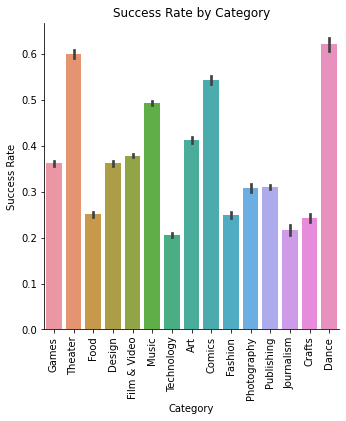

In [65]:
sns.catplot(x='main_category', y='goal_met', data=kicks, kind='bar')

plt.title('Success Rate by Category')
plt.xlabel('Category')
plt.ylabel('Success Rate')
plt.xticks(rotation=90)

plt.show()

It looks like the 'Dance' and 'Theater' categories have the highest success rates of all categories. What about the overall success rate across all categories? We will need this information later to determine the value of our models.



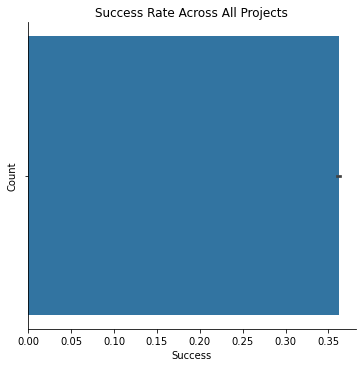

In [66]:
# Determine overall success rate for the data
sns.catplot(x='goal_met', data=kicks, kind='bar')

plt.title('Success Rate Across All Projects')
plt.xlabel('Success')
plt.ylabel('Count')

plt.show()

It looks like about 35% of projects succeed, so 65% fail. Let's build a couple graphs to better undrstand the relationships between some of our variables.

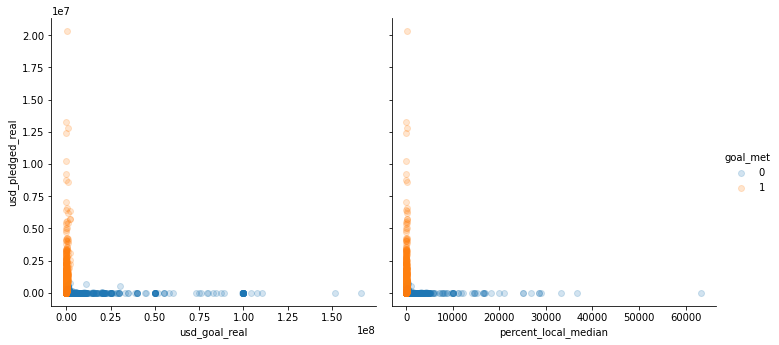

In [67]:
# Build graphs to compare the pledged amount to the goal amount, and the pledged amount to th goal normalized to the local median.
graph = sns.PairGrid(kicks, y_vars=["usd_pledged_real"], x_vars=["usd_goal_real", "percent_local_median"], height=4.5, hue="goal_met", aspect=1.1)
axes = graph.map(plt.scatter, alpha=0.2)
graph.add_legend();

It looks like there are some major outliers in the 'goal' section. Let's try and remove outliers that are more than 3 standard deviations away from the mean in the goal category. This should help our supervised models to peform better.

In [0]:
# Create a column with the standard deviation of the usd_goal_real variable
kicks_std = kicks.copy()
kicks_std = kicks_std[['category', 'usd_goal_real']]

In [0]:
category_mean = kicks_std.groupby(['category']).mean()

category_mean.rename(columns = {'usd_goal_real':'local_mean'}, inplace = True) 
kicks_std = pd.merge(kicks_std, category_mean, how='left',on='category')

category_std = kicks_std.groupby(['category']).std()

category_std.rename(columns = {'usd_goal_real':'local_std'}, inplace = True) 
kicks_std = pd.merge(kicks_std, category_std, how='left',on='category')

In [70]:
# Build a variable for standard deviation of each observation
kicks_std['usd_goal_category_stdcount'] = (kicks_std['usd_goal_real'] - kicks_std['local_mean_x'])/kicks_std['local_std']
kicks_std.info()
kicks_std.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 0 to 378660
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   category                    378661 non-null  object 
 1   usd_goal_real               378661 non-null  float64
 2   local_mean_x                378661 non-null  float64
 3   local_std                   378661 non-null  float64
 4   local_mean_y                378661 non-null  float64
 5   usd_goal_category_stdcount  378661 non-null  float64
dtypes: float64(5), object(1)
memory usage: 20.2+ MB


,category,usd_goal_real,local_mean_x,local_std,local_mean_y,usd_goal_category_stdcount
0,Video Games,333000.00,76740.858763,1.113404e+06,0.0,0.230158
1,Musical,3433.54,54186.796813,6.434186e+05,0.0,-0.078881
2,Food,50000.00,40107.303969,1.559156e+06,0.0,0.006345
3,Graphic Design,499.00,6871.783951,1.745642e+04,0.0,-0.365068
4,Film & Video,2100.00,81139.195471,1.148685e+06,0.0,-0.068808


In [71]:
# Add the STD variable into kicks
kicks['usd_goal_category_stdcount'] = kicks_std['usd_goal_category_stdcount']

# Delete all rows for which column 'usd_goal_real' has absolute value greater than 3  
kicks.drop(kicks[kicks.usd_goal_category_stdcount >= 3].index, inplace=True)
kicks.drop(kicks[kicks.usd_goal_category_stdcount <= -3].index, inplace=True)

kicks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377311 entries, 0 to 378660
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   ID                          377311 non-null  int64         
 1   category                    377311 non-null  object        
 2   main_category               377311 non-null  object        
 3   deadline                    377311 non-null  datetime64[ns]
 4   launched                    377311 non-null  datetime64[ns]
 5   status                      377311 non-null  object        
 6   backers                     377311 non-null  int64         
 7   country                     377311 non-null  object        
 8   usd_pledged_real            377311 non-null  float64       
 9   usd_goal_real               377311 non-null  float64       
 10  percent_goal                377311 non-null  float64       
 11  goal_met                    377311 non-

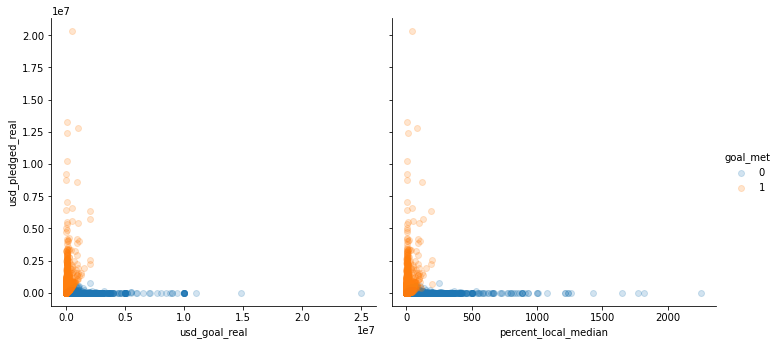

In [72]:
# Build the same plots as before, without the outliers.
graph = sns.PairGrid(kicks, y_vars=["usd_pledged_real"], x_vars=["usd_goal_real", "percent_local_median"], height=4.5, hue="goal_met", aspect=1.1)
axes = graph.map(plt.scatter, alpha=0.2)
graph.add_legend();

We can see here that by removing outliers we can better identify the relationships with 'usd_pledged_real'. though there are still some outliers, we dont' want to lose too much data, so we will leave it as is.

Now that we have finished dropping and crafting variables, here is the definition index of each variable we are using:

 0   ID: Unique ID number for each observation         
 1   category: Granular subcategory describing the project        
 2   main_category: Condensed umbrella category describing the project      
 3   deadline: the date at which the funding campaign will end
 4   launched: the date at which the funding campaign began
 5   status: the status of the campaign as of 1/2/2018     
 6   backers: the number of backers that supported the project         
 7   country: the country in which the project originated   
 8   usd_pledged_real: total value pledged in USD       
 9   usd_goal_real: total value of goal set in USD 
 10  percent_goal: percentage of set goal attained, based on pledge value       
 11  goal_met: Binary check to see whether percent_goal exceedeed 100%      
 12  campaign_duration: duration of the campagin in days

 13  percent_global_median: Fraction of the median of all project goals
 
 14  percent_local_median: Fraction of the median of all project goals within the observations home category
 
 15  usd_goal_category_stdcount: Number of standard deviations away from the mean of the observations home category

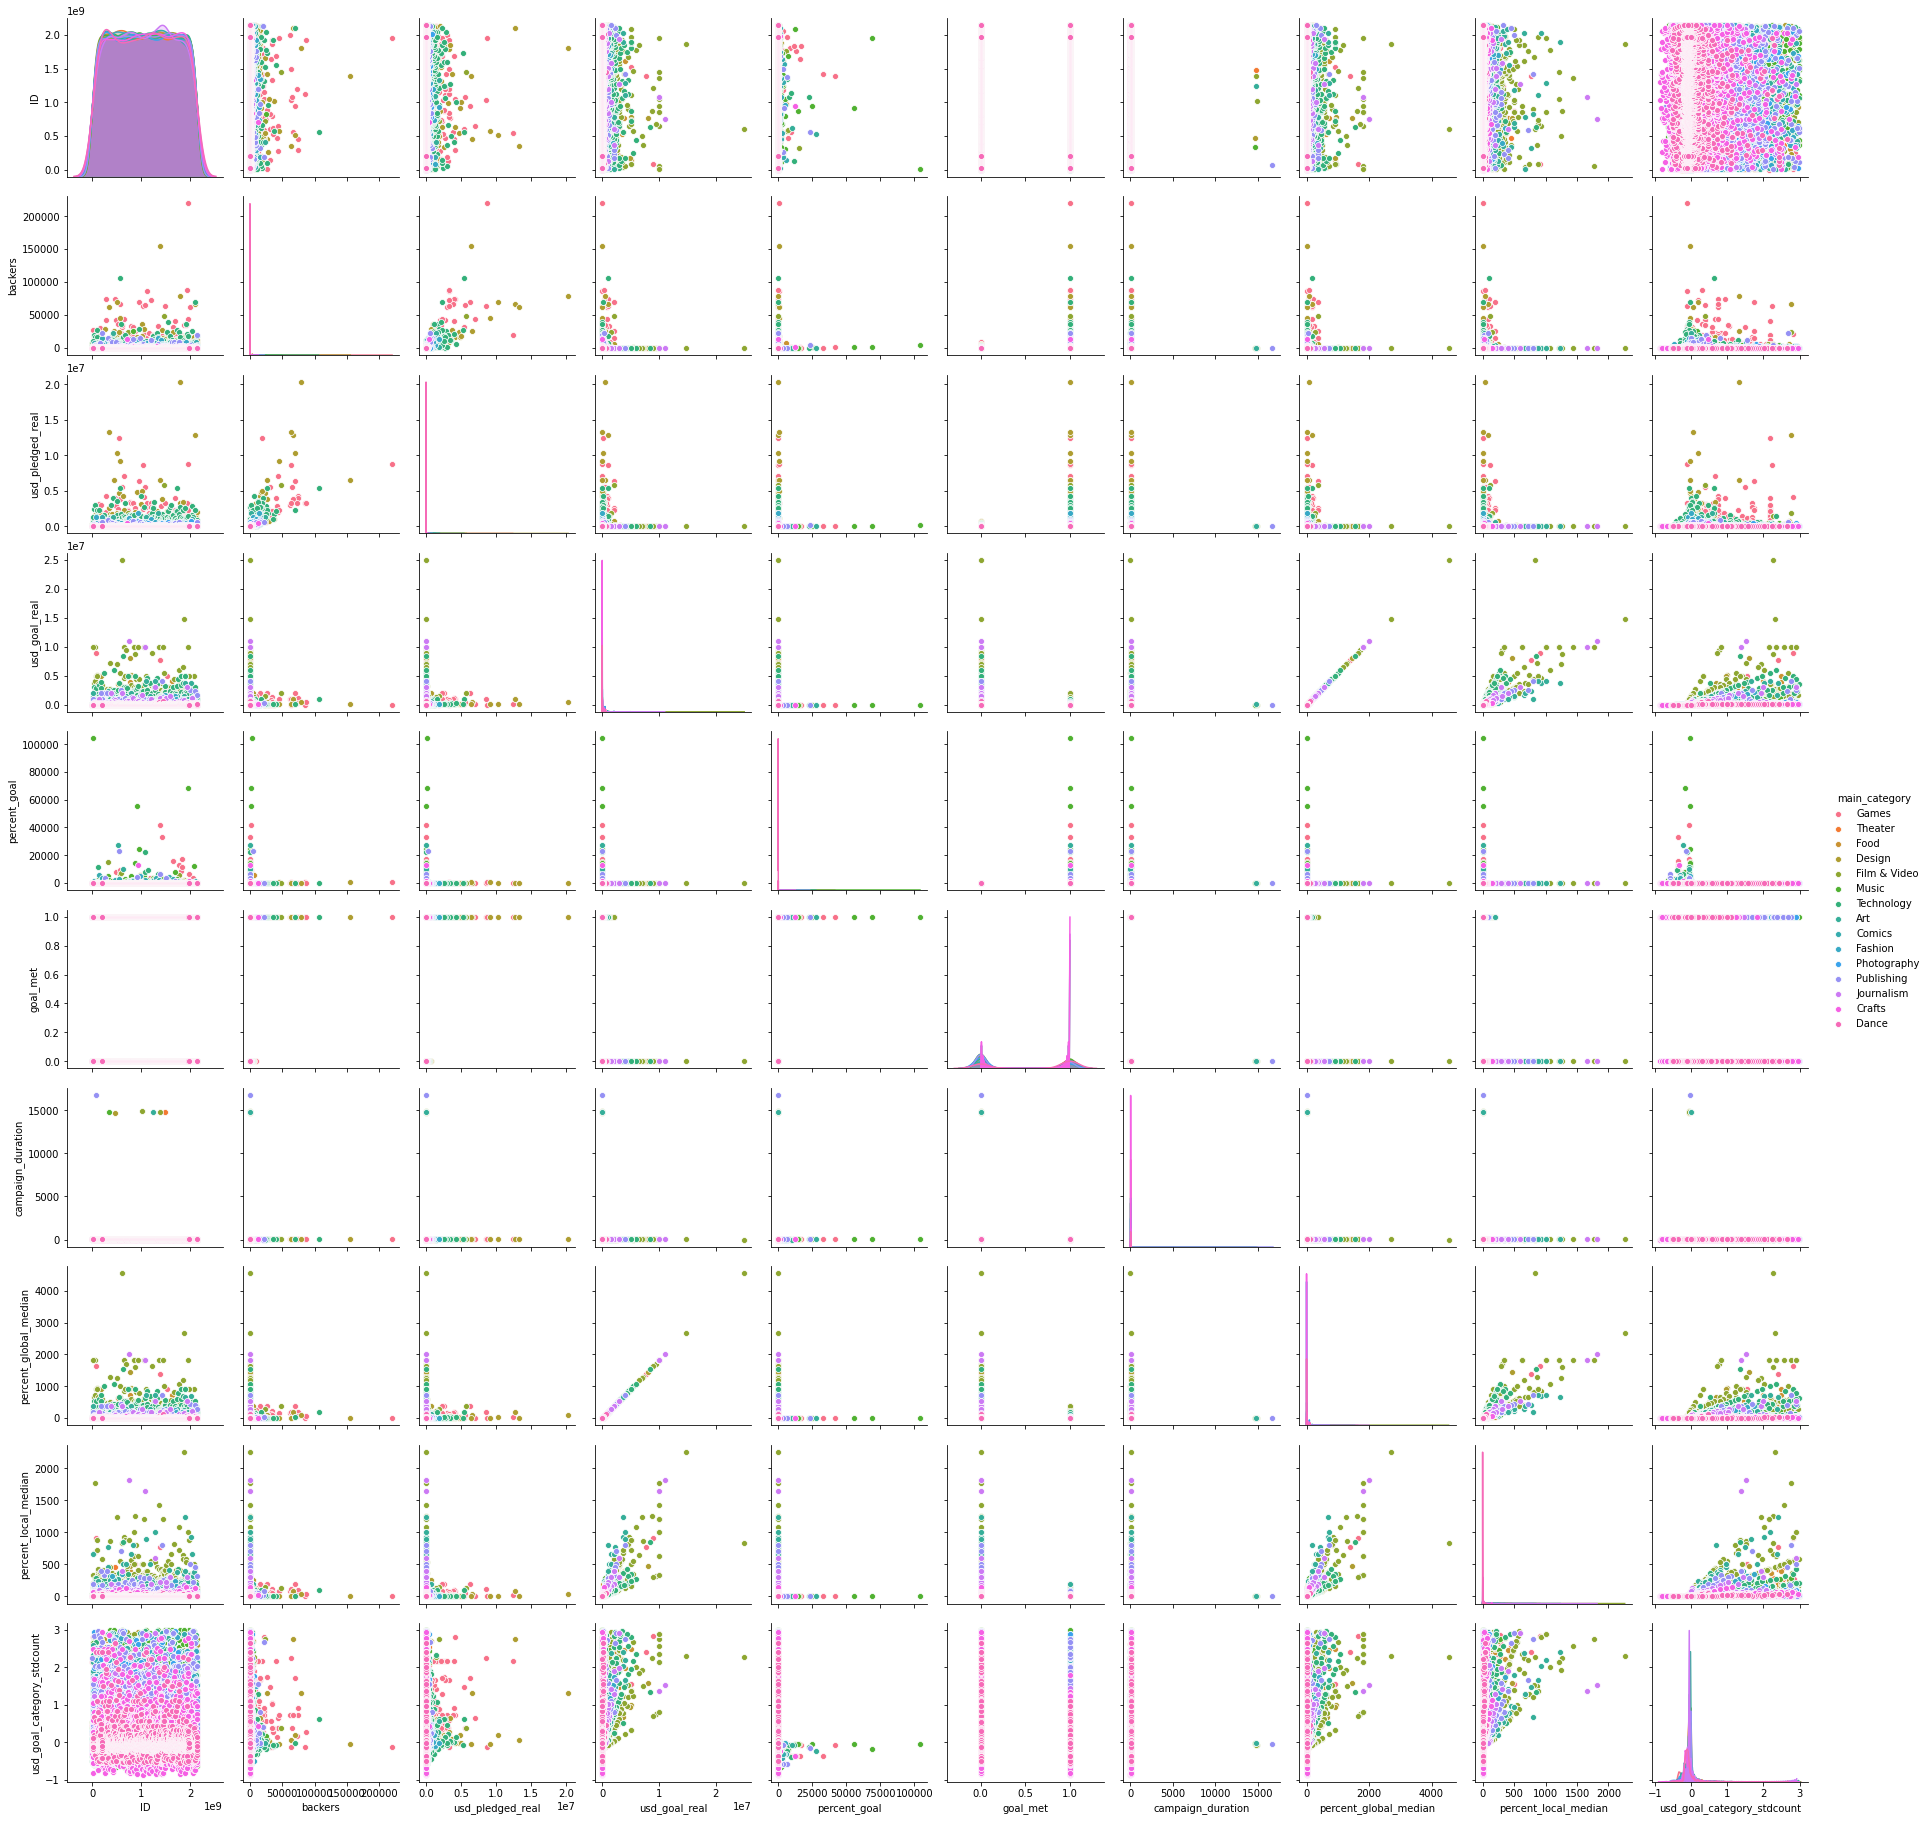

In [73]:
sns.pairplot(kicks, hue='main_category', height=2.5)

Overall, the data is relatively clean now, and there are a large number of ways to look at it. Let's move on to our supervised machine learning models to see fi we can predict the success or failure of a project.

# Supervised Machine Learning Analysis

In [0]:
# Build separate data sets for linear and classification models
kicks_LinReg = kicks.copy()
kicks_Class = kicks.copy()

# Drop meta variables and variables that contain too much information about project success for each model type
kicks_LinReg = kicks_LinReg.drop(columns=['status', 'deadline', 'launched', 'ID', 'backers','usd_pledged_real', 'goal_met'])
kicks_Class = kicks_Class.drop(columns=['status', 'deadline', 'launched', 'ID', 'backers','usd_pledged_real', 'percent_goal'])

# Build dummy variables for each model data set
kicks_LinReg = pd.get_dummies(kicks_LinReg, columns=['category','main_category', 'country'])
kicks_Class = pd.get_dummies(kicks_Class, columns=['category','main_category', 'country'])

Here we are building two separate dataframes: one for linear regression, and one for classification models. We are removing all meta variables, like ID, that do not have any predictive power. We are also removing the date variables, as well as the pledge amounts and number of backers. While the pledge amounts and number of backers likely have excellent predcitive power, they essentially "give away" to the model whether it will succeed or fail. Giving the model the amount pledged will inform it as to whether the campagin reached its goal. While backers likely isn't quite as strong a predicitor, it is also not under the control of a company starting a kickstarter campaign. A company can set the campaign duration, the goal amount, and the category, but they cannot decide how many backers they are going to get. Therefore, we have removed backers as well.

In [75]:
kicks_LinReg.head(2)

,usd_goal_real,percent_goal,campaign_duration,percent_global_median,percent_local_median,usd_goal_category_stdcount,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,...,category_Young Adult,category_Zines,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,333000.00,0.000036,29,60.545455,31.881252,0.230158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,3433.54,1.000000,29,0.624280,0.686708,-0.078881,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Split the data into training and test test for linear and classification models
X_Lin = kicks_LinReg.drop('percent_goal', axis=1)
y_Lin = kicks_LinReg['percent_goal']
X_Lin_train, X_Lin_test, y_Lin_train, y_Lin_test = train_test_split(X_Lin, y_Lin, test_size=0.30, random_state=42) 

X_Class = kicks_Class.drop('goal_met', axis=1)
y_Class = kicks_Class['goal_met']
X_Class_train, X_Class_test, y_Class_train, y_Class_test = train_test_split(X_Class, y_Class, test_size=0.30, random_state=42) 

In [77]:
# Build Linear Regression
LinReg = LinearRegression(fit_intercept=True)
LinReg.fit(X_Lin_train, y_Lin_train)
y_LinReg = LinReg.predict(X_Lin_test)

# Scoring the linear regression
print('Mean Absolute Error:', metrics.mean_absolute_error(y_Lin_test, y_LinReg))  
print('Mean Squared Error:', metrics.mean_squared_error(y_Lin_test, y_LinReg))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_Lin_test, y_LinReg)))
print('R-squared:', metrics.r2_score(y_Lin_test, y_LinReg))

Mean Absolute Error: 6.41227553768134
Mean Squared Error: 165460.37212193725
Root Mean Squared Error: 406.7682044136897
R-squared: 8.770466772256569e-05


The linear regression performed extremely poorly on the information provided, indicating that there is no linear relationship between the percent of goal met and the information contained within our feature matrix. Let's try some classification models instead.

In [0]:
# Build Logistic Regression model
LogReg = LogisticRegression(solver = 'liblinear')
LogReg.fit(X_Class_train, y_Class_train)
y_LogReg = LogReg.predict(X_Class_test)

In [0]:
# Build KNN model
KNN = KNeighborsClassifier(n_neighbors=10)
KNN.fit(X_Class_train, y_Class_train)
y_KNN = KNN.predict(X_Class_test)

In [0]:
# Build Naive Bayes model
NB = GaussianNB()
NB.fit(X_Class_train, y_Class_train)
y_NB = NB.predict(X_Class_test)

In [81]:
#Scoring Classification Models
print('Logistic Regression:\n', metrics.classification_report(y_Class_test, y_LogReg))
print('KNN:\n', metrics.classification_report(y_Class_test, y_KNN))
print('Naive Bayes:\n', metrics.classification_report(y_Class_test, y_NB))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78     72097
           1       0.00      0.00      0.00     41097

    accuracy                           0.64    113194
   macro avg       0.32      0.50      0.39    113194
weighted avg       0.41      0.64      0.50    113194

KNN:
               precision    recall  f1-score   support

           0       0.69      0.85      0.76     72097
           1       0.55      0.33      0.41     41097

    accuracy                           0.66    113194
   macro avg       0.62      0.59      0.59    113194
weighted avg       0.64      0.66      0.63    113194

Naive Bayes:
               precision    recall  f1-score   support

           0       0.88      0.09      0.16     72097
           1       0.38      0.98      0.55     41097

    accuracy                           0.41    113194
   macro avg       0.63      0.53      0.35    113194
weighted avg       0.70      0.4

We see that all of our models performed quite poorly with the information provided to them, though marginally better than the linear model. In fact, both the logistic regression and KNN are about as effective as randomly guessing whether a project succeeded or failed (35% of projects succeed overall, so 65% fail). This indicates that there are other factors that are stronger predictors of success and failure. Let's try the regressions again, but we'll add back the 'backers' variable. Naive Bayes performed so poorly that we wont' bother running that again.

In [0]:
# Rebuild data set to include 'backers'
kicks_Class2 = kicks.copy()
kicks_Class2 = kicks_Class2.drop(columns=['status', 'deadline', 'launched', 'ID','usd_pledged_real', 'percent_goal'])
kicks_Class2 = pd.get_dummies(kicks_Class2, columns=['category','main_category', 'country'])

X_Class2 = kicks_Class2.drop('goal_met', axis=1)
y_Class2 = kicks_Class2['goal_met']
X_Class2_train, X_Class2_test, y_Class2_train, y_Class2_test = train_test_split(X_Class2, y_Class2, test_size=0.30, random_state=42) 

In [0]:
# Build new Logistic Regression model
LogReg2 = LogisticRegression(solver = 'liblinear')
LogReg2.fit(X_Class2_train, y_Class2_train)
y_LogReg2 = LogReg2.predict(X_Class2_test)

In [0]:
# Build KNN model
KNN2 = KNeighborsClassifier(n_neighbors=10)
KNN2.fit(X_Class2_train, y_Class2_train)
y_KNN2 = KNN2.predict(X_Class2_test)

In [85]:
#Scoring Classification Models
print('Logistic Regression 2:\n', metrics.classification_report(y_Class2_test, y_LogReg2))
print('KNN 2:\n', metrics.classification_report(y_Class2_test, y_KNN2))

Logistic Regression 2:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92     72097
           1       0.92      0.79      0.85     41097

    accuracy                           0.90    113194
   macro avg       0.91      0.88      0.89    113194
weighted avg       0.90      0.90      0.90    113194

KNN 2:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     72097
           1       0.90      0.87      0.89     41097

    accuracy                           0.92    113194
   macro avg       0.91      0.91      0.91    113194
weighted avg       0.92      0.92      0.92    113194



Simply by adding the 'backers' variable, our model performance has jumped to around 0.90. This is a rather intuitive finding, as more backers means more money, and a higher likelihood of success. Unforunately, this isn't very useful for an entrepreneur trying to assess whether Kickstarter is a valuable option for them. Perhaps the best indicator this gives us is that a company thinking about using Kickstarter is best positioned if they already have a pre-existing fan-base that trusts them, and an extensive social network that can be tapped for funding. A small company with no reputation is likely to find that Kickstarter is an unforgiving place.

# Unsupervised Machine Learning Analysis

Let's try doing some unsuperzised learning with a Principal Component Analysis. We'll start with 3 principal components, because 3D graphs are fun.

In [0]:
# Build separate dataframes for features and target of unsupervised learning
kicks_unsup = kicks.copy()
kicks_unsup = kicks_unsup.drop(['ID','deadline','status','percent_goal','launched','country', 'category', 'usd_pledged_real', 'main_category', 'backers'], axis=1)
X_kicks_unsup = kicks_unsup.drop('goal_met', axis=1)  # features matrix
y_kicks_unsup = kicks_unsup['goal_met']               # target vector

# Instantiate, normalize, fit, and transform PCA model
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=3))])
pipeline.fit(X_kicks_unsup)
X_3D = pipeline.transform(X_kicks_unsup) 

# Build dataframe with only PCA features and target for each observation
kicks_pca = pd.DataFrame()
kicks_pca['PCA1'] = X_3D[:, 0]
kicks_pca['PCA2'] = X_3D[:, 1]
kicks_pca['PCA3'] = X_3D[:, 2]
kicks_pca['goal_met'] = kicks_unsup['goal_met']

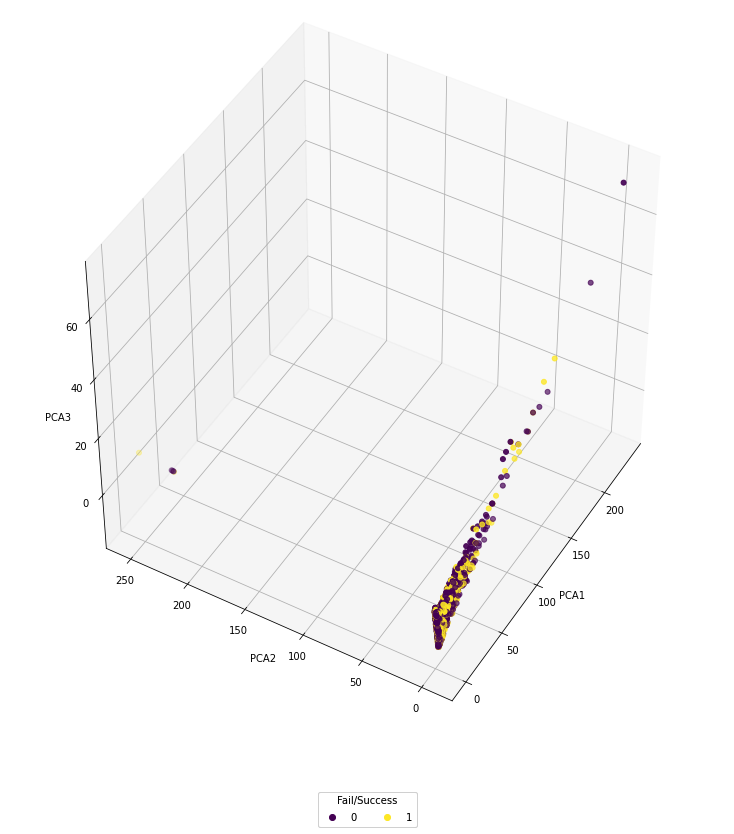

In [87]:
# Build figure space
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

# Define graph
g = ax.scatter(kicks_pca['PCA1'], kicks_pca['PCA2'], kicks_pca['PCA3'], c=kicks_pca['goal_met'], s=25)
ax.view_init(45, 210)

# Set Axis Labels
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

# Build legend
legend = ax.legend(*g.legend_elements(), loc="lower center", title="Fail/Success", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

# Display plot
plt.show()

This is a cool plot, but it looks like our PCA2 and PCA3 don't do much individually to explain success or failure. It looks like PCA1 explains almost all of the variance, while PCA2 and PCA3 don't explain much. Let's collapse the PCA model down to 2 principal components to combine the explained variance of PCA2 and PCA3.

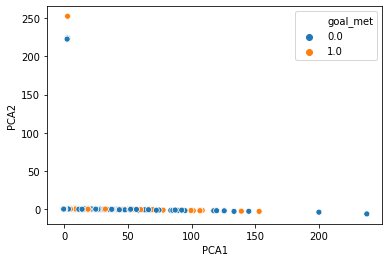

In [88]:
# Instantiate, normalize, fit, and transform PCA model
pipeline2 = Pipeline([('scaling2', StandardScaler()), ('pca2', PCA(n_components=2))])
pipeline2.fit(X_kicks_unsup)
X_2D = pipeline2.transform(X_kicks_unsup) 

# Build dataframe with only PCA features and target for each observation
kicks_pca2 = pd.DataFrame()
kicks_pca2['PCA1'] = X_2D[:, 0]
kicks_pca2['PCA2'] = X_2D[:, 1]
kicks_pca2['goal_met'] = kicks_unsup['goal_met']

# Build PCA plot
sns.scatterplot('PCA1', 'PCA2', data=kicks_pca2, hue='goal_met')

From the graph, it looks like successes and failutres are fairly randomly distributed, indicating that the PCA did not do a very good job of identifiying principal components that would help up predict success or failure.

Overall, our methods didn't do well in meaningfully predicting success or failure of a Kickstarter campaign when provided with the information that an entrepreneur would know at the start of a campaign. When provided information regarding number of backers, the predictive power grew considerably, but this result could have been determined intuitively: Kickstarter is a crowdfunding platform, and success on the platform is reliant on drawing crowds, not on a few influential backers.